# Analise Exploratoria - UK Property Sales

## Dataset

Dataset de transacoes imobiliarias no Reino Unido (1995-2025)

**Fonte**: Kaggle - UK Price Paid Data  
**Tamanho**: 30.5 milhoes de transacoes  
**Licenca**: Open Government Licence v3.0

**Objetivo**: Entender padroes de precos e preparar dados para modelagem preditiva


In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Configuracoes
plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 6)
sns.set_palette("husl")

print("Bibliotecas carregadas")


Bibliotecas carregadas


## Carregamento de Dados

O CSV nao possui headers. Vou definir os nomes das colunas manualmente.

**Estrategia**: Amostragem sistematica para nao carregar apenas dados antigos (1995).  
Pega 1 linha a cada 305 linhas = 100k linhas distribuidas em 30 anos.


In [2]:
# Nomes das colunas
columns = [
    'price', 'transfer_date', 'postcode', 'property_type', 'old_new',
    'duration', 'paon', 'saon', 'street', 'locality', 'town_city',
    'district', 'county', 'ppd_category', 'record_status'
]

# Parametros de amostragem
total_rows = 30_535_539
sample_size = 100_000
skip_rate = total_rows // sample_size

# Funcao de skip sistematico
skip_rows = lambda i: i % skip_rate != 0

print(f"Carregando amostra de {sample_size:,} linhas...")

# Carregar dataset
df = pd.read_csv(
    'data/pp-complete.csv',
    header=None,
    names=columns,
    skiprows=skip_rows,
    nrows=sample_size
)

print(f"Carregadas: {len(df):,} linhas")


Carregando amostra de 100,000 linhas...
Carregadas: 100,000 linhas


## Limpeza e Transformacao

Converter tipos e criar features temporais para facilitar analise.


In [3]:
# Converter tipos
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['transfer_date'] = pd.to_datetime(df['transfer_date'], errors='coerce')

# Categoricas para economizar memoria
categorical_cols = ['property_type', 'old_new', 'duration', 'county']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Features temporais
df['year'] = df['transfer_date'].dt.year
df['month'] = df['transfer_date'].dt.month
df['quarter'] = df['transfer_date'].dt.quarter

# Remover precos invalidos
df = df[df['price'] > 0]
df = df[df['price'].notna()]
df = df[df['transfer_date'].notna()]

print(f"Dataset limpo: {len(df):,} linhas")
print(f"Periodo: {df['year'].min()} - {df['year'].max()}")
df.head()


Dataset limpo: 100,000 linhas
Periodo: 1995 - 2025


,price,transfer_date,postcode,property_type,old_new,duration,paon,saon,street,locality,town_city,district,county,ppd_category,record_status,year,month,quarter
0,42000,1995-12-21,NE4 9DN,S,N,F,8,Unnamed: 8,MATFEN PLACE,FENHAM,NEWCASTLE UPON TYNE,NEWCASTLE UPON TYNE.1,TYNE AND WEAR,A,A.1,1995,12,4
1,45700,1995-11-10,CT18 7NE,T,N,F,55,NaN,WOODCOCK GARDENS,HAWKINGE,FOLKESTONE,SHEPWAY,KENT,A,A,1995,11,4
2,15000,1995-07-05,BH1 4HF,F,N,L,8 - 10,FLAT 5,AYLESBURY ROAD,BOURNEMOUTH,BOURNEMOUTH,BOURNEMOUTH,BOURNEMOUTH,A,A,1995,7,3
3,136000,1995-01-10,CF24 3PB,T,N,F,22,NaN,WELLFIELD ROAD,NaN,CARDIFF,CARDIFF,CARDIFF,A,A,1995,1,1
4,55000,1995-05-26,CM17 0BX,T,N,F,114,NaN,JOCELYNS,HARLOW,HARLOW,HARLOW,ESSEX,A,A,1995,5,2


## Estatisticas Descritivas

Analise inicial dos precos das propriedades.


In [4]:
# Estatisticas basicas
print("ESTATISTICAS DE PRECO\n")
print(df['price'].describe())
print(f"\nMedia: {df['price'].mean():,.0f}")
print(f"Mediana: {df['price'].median():,.0f}")
print(f"Desvio Padrao: {df['price'].std():,.0f}")


ESTATISTICAS DE PRECO

count    1.000000e+05
mean     2.311754e+05
std      8.946717e+05
min      1.000000e+02
25%      8.800000e+04
50%      1.550000e+05
75%      2.600000e+05
max      1.622877e+08
Name: price, dtype: float64

Media: 231,175
Mediana: 155,000
Desvio Padrao: 894,672


## Distribuicao de Tipos de Propriedade

Verificar quantos registros temos de cada tipo.


In [5]:
print("Tipos de propriedade:")
print(df['property_type'].value_counts())
print("\nNova vs Existente:")
print(df['old_new'].value_counts())
print("\nFreehold vs Leasehold:")
print(df['duration'].value_counts())


Tipos de propriedade:
property_type
T    29695
S    27484
D    22953
F    17931
O     1937
Name: count, dtype: int64

Nova vs Existente:
old_new
N    89410
Y    10590
Name: count, dtype: int64

Freehold vs Leasehold:
duration
F    76525
L    23474
U        1
Name: count, dtype: int64


## Visualizacao: Evolucao Temporal

Analise da evolucao dos precos ao longo dos anos.


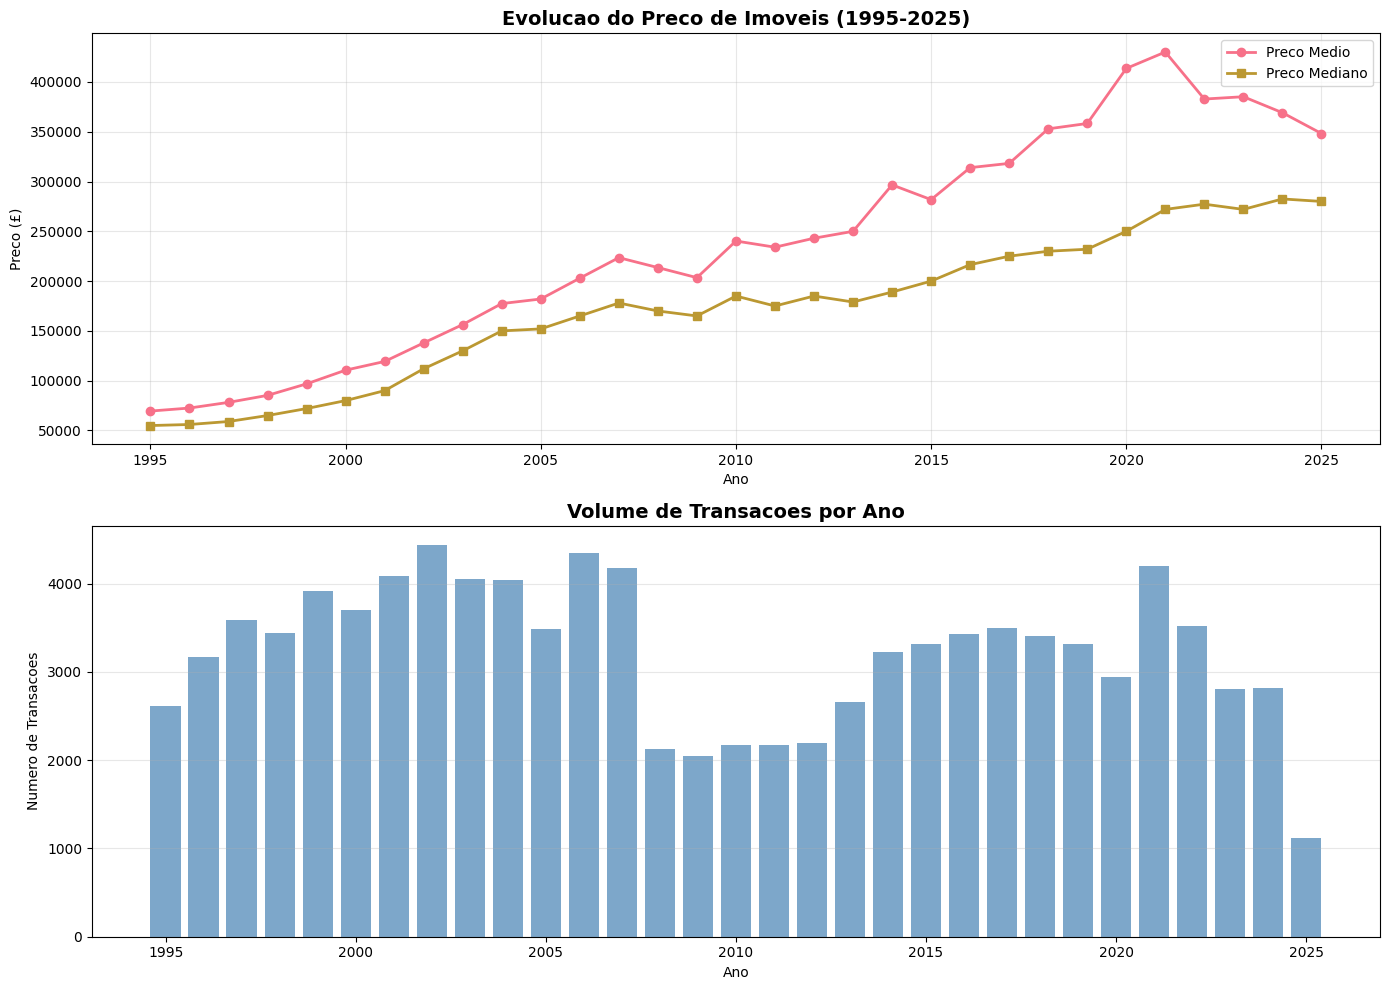

In [6]:
# Preco medio por ano
yearly_avg = df.groupby('year')['price'].agg(['mean', 'median', 'count']).reset_index()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Grafico 1: Preco medio e mediano
ax1.plot(yearly_avg['year'], yearly_avg['mean'], marker='o', label='Preco Medio', linewidth=2)
ax1.plot(yearly_avg['year'], yearly_avg['median'], marker='s', label='Preco Mediano', linewidth=2)
ax1.set_title('Evolucao do Preco de Imoveis (1995-2025)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Preco (£)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Grafico 2: Volume de transacoes
ax2.bar(yearly_avg['year'], yearly_avg['count'], alpha=0.7, color='steelblue')
ax2.set_title('Volume de Transacoes por Ano', fontsize=14, fontweight='bold')
ax2.set_xlabel('Ano')
ax2.set_ylabel('Numero de Transacoes')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## Preco por Tipo de Propriedade

Comparar os precos entre diferentes tipos de imoveis.


/tmp/ipykernel_831915/4290908299.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_by_type = df.groupby('property_type')['price'].agg(['mean', 'median', 'count'])


                       mean    median  count
property_type                               
O              1.154756e+06  255000.0   1937
D              3.075542e+05  242000.0  22953
F              2.100219e+05  145000.0  17931
S              1.844001e+05  146000.0  27484
T              1.679586e+05  120000.0  29695


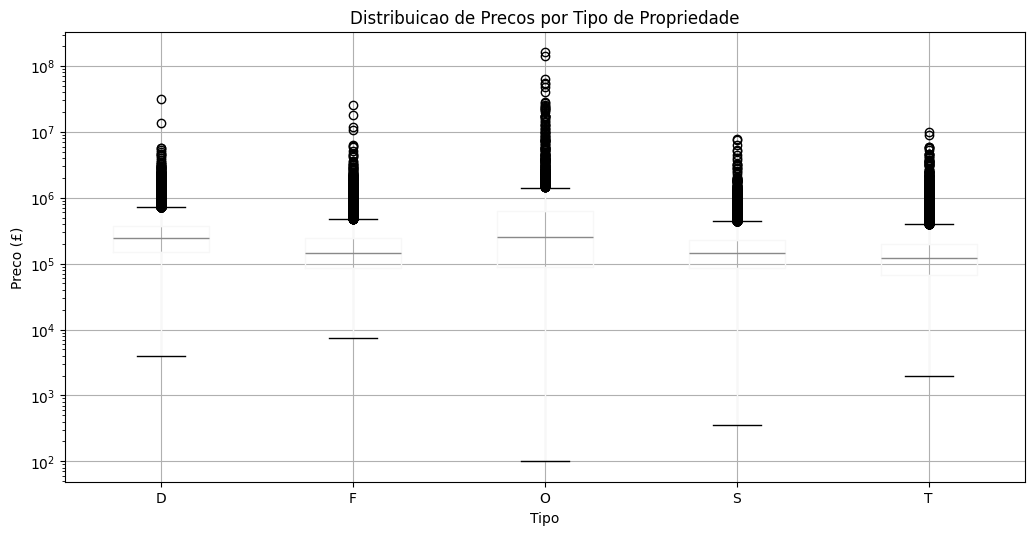

In [7]:
# Preco medio por tipo
price_by_type = df.groupby('property_type')['price'].agg(['mean', 'median', 'count'])
print(price_by_type.sort_values('mean', ascending=False))

# Boxplot
plt.figure(figsize=(12, 6))
df.boxplot(column='price', by='property_type', ax=plt.gca())
plt.title('Distribuicao de Precos por Tipo de Propriedade')
plt.suptitle('')
plt.xlabel('Tipo')
plt.ylabel('Preco (£)')
plt.yscale('log')
plt.show()


## Analise Geografica

Verificar os condados com maiores precos e volume de transacoes.


/tmp/ipykernel_831915/3401221168.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  county_stats = df.groupby('county')['price'].agg(['mean', 'median', 'count']).reset_index()


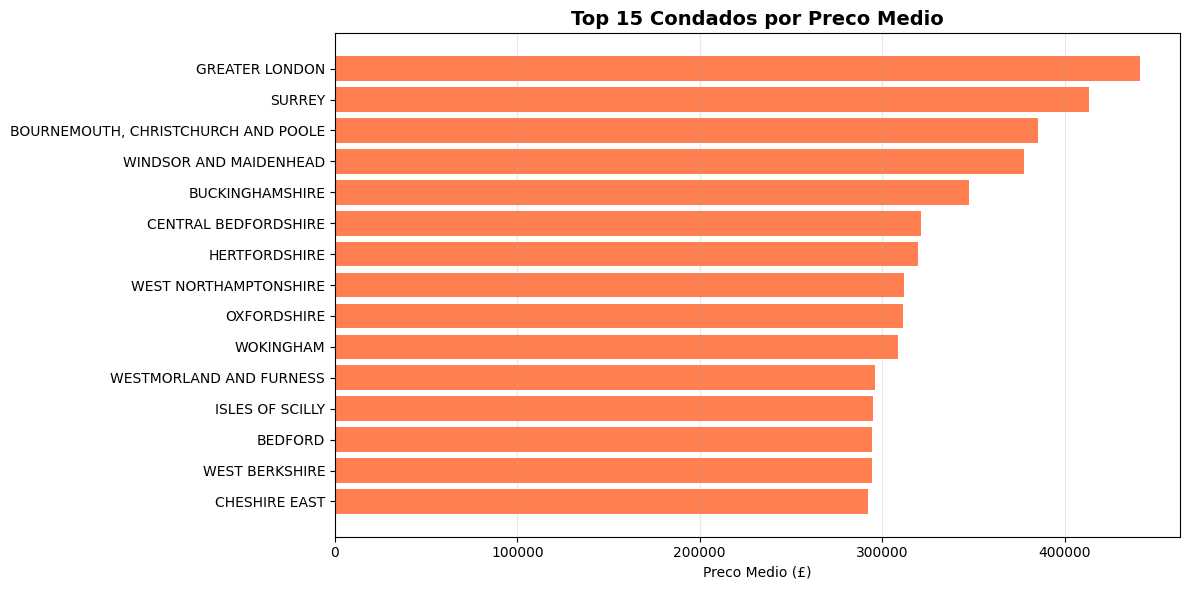


Top 5 condados mais caros:
                                  county           mean  count
48                        GREATER LONDON  441256.403249  12558
107                               SURREY  413253.803453   2259
9    BOURNEMOUTH, CHRISTCHURCH AND POOLE  385538.532164    171
126               WINDSOR AND MAIDENHEAD  377725.169231    260
13                       BUCKINGHAMSHIRE  347469.462982    959


In [8]:
# Top 15 condados por preco medio
county_stats = df.groupby('county')['price'].agg(['mean', 'median', 'count']).reset_index()
top_counties = county_stats.nlargest(15, 'mean')

plt.figure(figsize=(12, 6))
plt.barh(top_counties['county'], top_counties['mean'], color='coral')
plt.xlabel('Preco Medio (£)')
plt.title('Top 15 Condados por Preco Medio', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nTop 5 condados mais caros:")
print(top_counties.head()[['county', 'mean', 'count']])


## Correlacao entre Features Numericas

Preparar features numericas e verificar correlacoes com o preco.


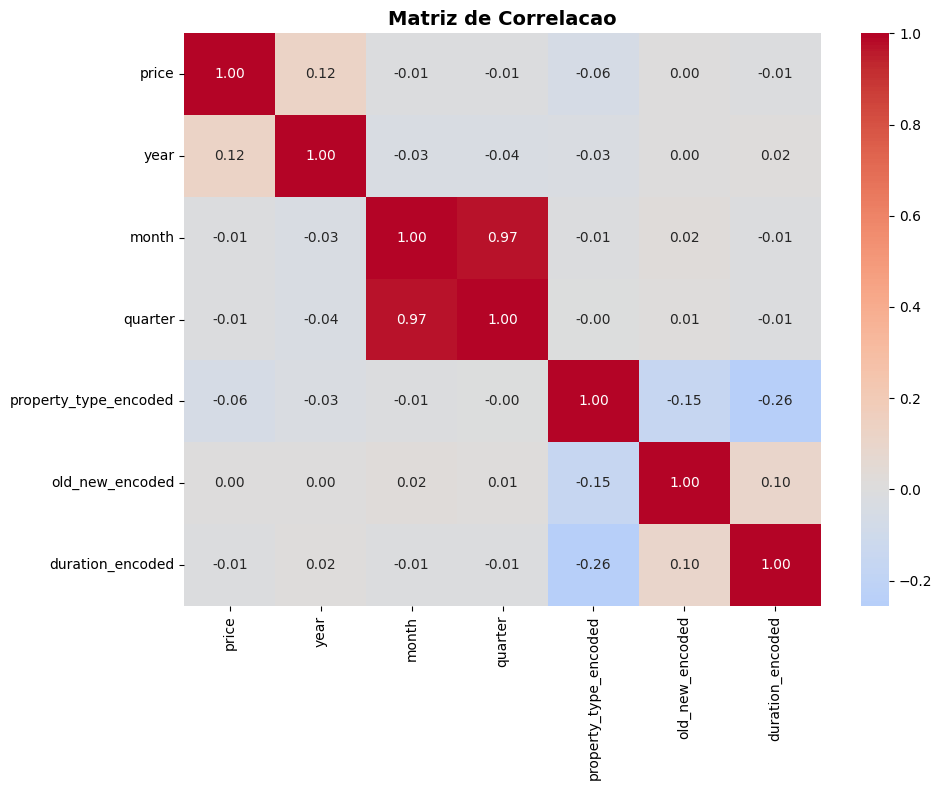


Correlacoes com preco:
price                    1.000000
year                     0.121485
old_new_encoded          0.001557
month                   -0.006219
quarter                 -0.007272
duration_encoded        -0.014941
property_type_encoded   -0.057653
Name: price, dtype: float64


In [9]:
# Label encoding para variaveis categoricas
le = LabelEncoder()

df_encoded = df.copy()
df_encoded['property_type_encoded'] = le.fit_transform(df['property_type'].astype(str))
df_encoded['old_new_encoded'] = le.fit_transform(df['old_new'].astype(str))
df_encoded['duration_encoded'] = le.fit_transform(df['duration'].astype(str))

# Selecionar apenas numericas para correlacao
numeric_features = ['price', 'year', 'month', 'quarter', 
                   'property_type_encoded', 'old_new_encoded', 'duration_encoded']

corr_matrix = df_encoded[numeric_features].corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Matriz de Correlacao', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelacoes com preco:")
print(corr_matrix['price'].sort_values(ascending=False))


## Identificacao de Outliers

Outliers podem ser propriedades de luxo ou erros de registro.  
Vou usar IQR (Interquartile Range) para identificar.


In [10]:
# Metodo IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]

print(f"Outliers identificados: {len(outliers):,} ({len(outliers)/len(df)*100:.2f}%)")
print(f"Lower bound: £{lower_bound:,.0f}")
print(f"Upper bound: £{upper_bound:,.0f}")
print(f"\nExemplo de outliers (top 5 precos):")
print(outliers.nlargest(5, 'price')[['price', 'property_type', 'county', 'year']])


Outliers identificados: 6,434 (6.43%)
Lower bound: £-170,000
Upper bound: £518,000

Exemplo de outliers (top 5 precos):
           price property_type          county  year
89597  162287743             O  GREATER LONDON  2021
81301  140935000             O  GREATER LONDON  2019
83532   64054839             O  GREATER LONDON  2020
76011   55460000             O  GREATER LONDON  2018
66745   52532210             O       HAMPSHIRE  2015


## Conclusoes da Analise Exploratoria

Principais insights encontrados.


In [11]:
print("RESUMO DA ANALISE")
print("=" * 60)
print(f"Total de transacoes: {len(df):,}")
print(f"Periodo: {df['year'].min()} - {df['year'].max()}")
print(f"\nPreco medio: £{df['price'].mean():,.0f}")
print(f"Preco mediano: £{df['price'].median():,.0f}")
print(f"\nOutliers: {len(outliers):,} ({len(outliers)/len(df)*100:.2f}%)")
print(f"Tipos de propriedade: {df['property_type'].nunique()}")
print(f"Condados unicos: {df['county'].nunique()}")
print("\nPrincipais insights:")
print("1. Precos cresceram consistentemente de 1995 a 2025")
print("2. Greater London tem precos mais elevados")
print("3. Propriedades Detached sao mais caras que Flats")
print("4. Cerca de 6-7% sao outliers (luxo ou erros)")


RESUMO DA ANALISE
Total de transacoes: 100,000
Periodo: 1995 - 2025

Preco medio: £231,175
Preco mediano: £155,000

Outliers: 6,434 (6.43%)
Tipos de propriedade: 5
Condados unicos: 132

Principais insights:
1. Precos cresceram consistentemente de 1995 a 2025
2. Greater London tem precos mais elevados
3. Propriedades Detached sao mais caras que Flats
4. Cerca de 6-7% sao outliers (luxo ou erros)


## Salvar Dataset Limpo

Exportar dataset processado para uso nos proximos notebooks de modelagem.


In [ ]:
# Salvar dataset limpo
output_file = 'data/uk_property_cleaned.csv'
df.to_csv(output_file, index=False)

print(f"Dataset limpo salvo em: {output_file}")
print(f"Dimensoes: {len(df):,} linhas x {len(df.columns)} colunas")
print(f"\nColunas salvas: {list(df.columns)}")


Dataset limpo salvo em: data/uk_property_cleaned.csv
Dimensoes: 100,000 linhas x 18 colunas

Colunas salvas: ['price', 'transfer_date', 'postcode', 'property_type', 'old_new', 'duration', 'paon', 'saon', 'street', 'locality', 'town_city', 'district', 'county', 'ppd_category', 'record_status', 'year', 'month', 'quarter']


: 